In [1]:
## import packages
from datetime import datetime
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import hail as hl

Loading BokehJS ...

In [3]:
# set up hail
hl.init(default_reference = "GRCh38")

/opt/conda/lib/python3.10/site-packages/hail/context.py:352: UserWarning:

Using hl.init with a default_reference argument is deprecated. To set a default reference genome after initializing hail, call `hl.default_reference` with an argument to set the default reference genome.

/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://all-of-us-11150-m.us-central1-b.c.terra-vpc-sc-fd39b54c.internal:41791
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130.post1-c69cd67afb8b
LOGGING: writing

In [4]:
bucket = os.getenv('WORKSPACE_BUCKET')

## Array

In [5]:
mt_array_path = os.getenv("MICROARRAY_HAIL_STORAGE_PATH")
mt_array = hl.read_matrix_table(mt_array_path)
mt_array = mt_array.key_rows_by("locus")

In [5]:
# read HDL with the clumped variants
HDL_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/HDL_sumstats_checkpoint.ht")

In [6]:
# subset mt to clumped variants 
mt_array_HDL = mt_array.semi_join_rows(HDL_sumstats) #261583

In [7]:
Sample_quant = hl.import_table(f"{bucket}/Pheno/quant_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_quant = Sample_quant.key_by("person_id")
mt_array_HDL = mt_array_HDL.semi_join_cols(Sample_quant)
mt_array_HDL = mt_array_HDL.annotate_cols(**Sample_quant[mt_array_HDL.s])

2024-10-31 19:23:05.107 Hail: INFO: Reading table to impute column types 1) / 1]
2024-10-31 19:23:10.119 Hail: INFO: Loading <StructExpression of type struct{person_id: str, Age: int32, is_sex_Male: int32, is_sex_Female: int32, is_White: int32, is_Black_or_African_American: int32, is_Native_Hawaiian_or_Other_Pacific_Islander: int32, is_Asian: int32, is_Middle_Eastern_or_North_African: int32, is_gender_Male: int32, is_gender_Female: int32, is_Hispanic: int32, is_anc_pred_eur: int32, is_anc_pred_amr: int32, is_anc_pred_afr: int32, is_anc_pred_sas: int32, is_anc_pred_eas: int32, is_anc_pred_mid: int32, PC1: float64, PC2: float64, PC3: float64, PC4: float64, PC5: float64, PC6: float64, PC7: float64, PC8: float64, PC9: float64, PC10: float64, PC11: float64, PC12: float64, PC13: float64, PC14: float64, PC15: float64, PC16: float64, BMI: float64, Height: float64, DBP: float64, SBP: float64, HbA1c: float64, leukocyte: float64, Lymphocyte: float64, RBC: float64, Neutrophil: float64, Hemoglobin_

In [18]:
Sample_quant_df = pd.read_csv(f"{bucket}/Pheno/quant_all.tsv", sep='\t', dtype={'person_id': str})

In [ ]:
quant_eur = Sample_quant.filter(Sample_quant.is_anc_pred_eur == 1)
quant_amr = Sample_quant.filter(Sample_quant.is_anc_pred_amr == 1)
quant_afr = Sample_quant.filter(Sample_quant.is_anc_pred_afr == 1)

### Create ancestry specific MT

In [8]:
mt_array_HDL_eur = mt_array_HDL.filter_cols(mt_array_HDL.is_anc_pred_eur == 1)
mt_array_HDL_amr = mt_array_HDL.filter_cols(mt_array_HDL.is_anc_pred_amr == 1)
mt_array_HDL_afr = mt_array_HDL.filter_cols(mt_array_HDL.is_anc_pred_afr == 1)

### Annotate rows with allele frequency

In [9]:
mt_array_HDL_eur = mt_array_HDL_eur.annotate_rows(allele_freq = hl.agg.mean(mt_array_HDL_eur.GT.n_alt_alleles()) / 2)
mt_array_HDL_amr = mt_array_HDL_amr.annotate_rows(allele_freq = hl.agg.mean(mt_array_HDL_amr.GT.n_alt_alleles()) / 2)
mt_array_HDL_afr = mt_array_HDL_afr.annotate_rows(allele_freq = hl.agg.mean(mt_array_HDL_afr.GT.n_alt_alleles()) / 2)

In [10]:
mt_array_HDL_eur.rows().write(f"{bucket}/AF/array_HDL_eur.ht", overwrite=True)
mt_array_HDL_amr.rows().write(f"{bucket}/AF/array_HDL_amr.ht", overwrite=True)
mt_array_HDL_afr.rows().write(f"{bucket}/AF/array_HDL_afr.ht", overwrite=True)

2024-10-31 19:23:19.643 Hail: INFO: wrote table with 261583 rows in 1 partition to /tmp/__iruid_3552-GG8Z2e6eSzexSAWQB0x6UU
2024-10-31 20:03:53.026 Hail: INFO: wrote table with 261583 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_HDL_eur.ht
2024-10-31 20:03:59.630 Hail: INFO: wrote table with 261583 rows in 1 partition to /tmp/__iruid_7523-xQJchOlI1Sx4trADHVZeJp
2024-10-31 20:30:49.782 Hail: INFO: wrote table with 261583 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_HDL_amr.ht
2024-10-31 20:30:56.290 Hail: INFO: wrote table with 261583 rows in 1 partition to /tmp/__iruid_11494-CNLoebUVKTm8Ajm7zLaFJM
2024-10-31 21:06:19.954 Hail: INFO: wrote table with 261583 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_HDL_afr.ht


In [14]:
array_HDL_eur = hl.read_table(f"{bucket}/AF/array_HDL_eur.ht")
array_HDL_amr = hl.read_table(f"{bucket}/AF/array_HDL_amr.ht")
array_HDL_afr = hl.read_table(f"{bucket}/AF/array_HDL_afr.ht")

array_HDL_eur.export(f"{bucket}/AF/array_HDL_eur.gz")
array_HDL_amr.export(f"{bucket}/AF/array_HDL_amr.gz")
array_HDL_afr.export(f"{bucket}/AF/array_HDL_afr.gz")

2024-10-31 21:31:36.039 Hail: INFO: merging 75 files totalling 13.2M... 8) / 74]
2024-10-31 21:31:36.846 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_HDL_eur.gz
  merge time: 805.511ms
2024-10-31 21:31:43.263 Hail: INFO: merging 75 files totalling 13.1M...12) / 74]
2024-10-31 21:31:43.753 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_HDL_amr.gz
  merge time: 489.846ms
2024-10-31 21:31:46.171 Hail: INFO: merging 75 files totalling 13.1M...10) / 74]
2024-10-31 21:31:46.611 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_HDL_afr.gz
  merge time: 439.826ms


### Visualization

In [36]:
array_HDL_eur = pd.read_csv(f"{bucket}/AF/array_HDL_eur.gz",sep = "\t")
array_HDL_amr = pd.read_csv(f"{bucket}/AF/array_HDL_amr.gz",sep = "\t")
array_HDL_afr = pd.read_csv(f"{bucket}/AF/array_HDL_afr.gz",sep = "\t")

In [12]:
# Function to extract the second number in "AF"
import ast
def extract_af(info):
    # Convert the string representation of dictionary to a dictionary
    info_dict = ast.literal_eval(info)
    # Extract the second number from the "AF" list
    return info_dict['AF'][1]

In [13]:
# Apply the function to the 'info' column and create a new column 'AF_all'
array_HDL_eur['AF_all'] = array_HDL_eur['info'].apply(extract_af)
array_HDL_amr['AF_all'] = array_HDL_amr['info'].apply(extract_af)
array_HDL_afr['AF_all'] = array_HDL_afr['info'].apply(extract_af)

#### Histogram for AF_all

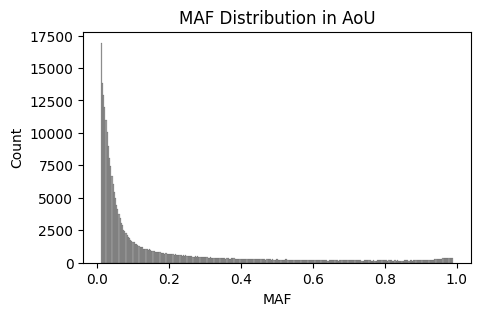

In [20]:
eur = array_HDL_eur

plt.figure(figsize=(5, 3))
sns.histplot(eur['AF_all'], bins=300, kde=False, color='grey')
plt.title("MAF Distribution in AoU")
plt.xlabel("MAF")
plt.ylabel("Count")
#plt.xlim(0, 0.5)
plt.show()

#### Histogram for new AF

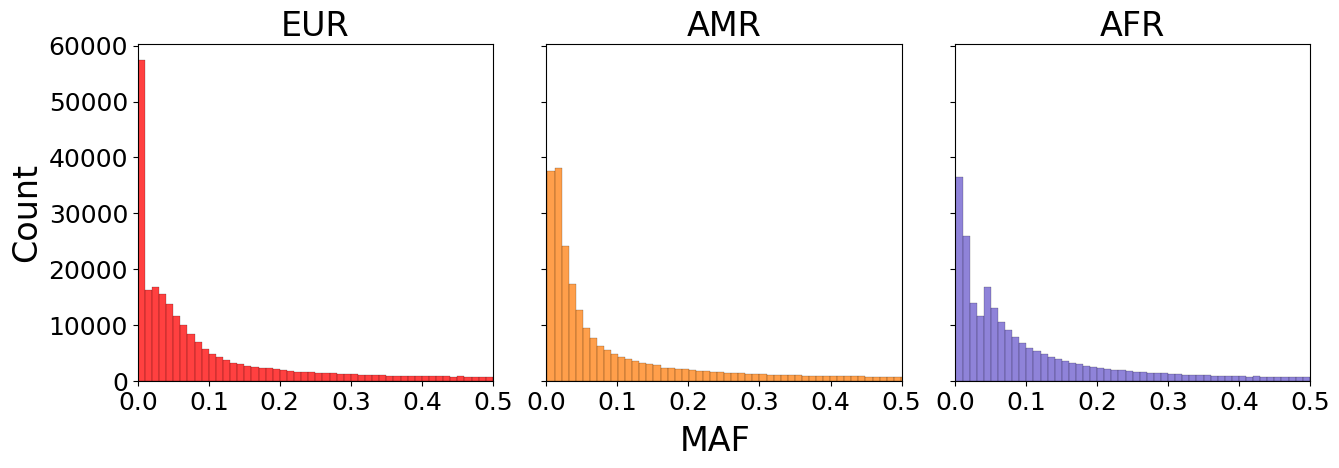

In [16]:
eur = array_HDL_eur
amr = array_HDL_amr
afr = array_HDL_afr

# Create a figure with a row of three subplots
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

# Plot each histogram in its respective subplot
sns.histplot(eur['allele_freq'], bins=100, kde=False, color='red', ax=axes[0])
axes[0].set_title("EUR", fontsize=24)
axes[0].set_ylabel("Count", fontsize=24)
axes[0].set_xlabel('', fontsize=20)
axes[0].set_xlim(0, 0.5)

sns.histplot(amr['allele_freq'], bins=100, kde=False, color='#ff7f0e', ax=axes[1])
axes[1].set_title("AMR", fontsize=24)
axes[1].set_xlabel('', fontsize=20)
axes[1].set_xlim(0, 0.5)

sns.histplot(afr['allele_freq'], bins=100, kde=False, color='slateblue', ax=axes[2])
axes[2].set_title("AFR", fontsize=24)
axes[2].set_xlabel('', fontsize=20)
axes[2].set_xlim(0, 0.5)

# Set a shared x-axis label
fig.text(0.8, -0.02, 'MAF', ha='center', fontsize=24)

# Increase tick label font size for all axes
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=18)

# Adjust the number of ticks on x-axis and y-axis if needed
for ax in axes:
    ax.set_xticks([i * 0.1 for i in range(6)])  # Example for 0, 0.1, 0.2,..., 0.5
    ax.set_yticks(range(0, 60001, 10000)) 
    
# Adjust layout and space between subplots
plt.tight_layout(rect=[0, 0.05, 1.5, 1.5], w_pad=1)  # Increase w_pad for more space between subplots

# Show the plot
plt.show()

In [51]:
# Summarize allele frequency for each ancestry
print("EUR AF Summary:")
print(eur['allele_freq'].describe())

print("\nAMR AF Summary:")
print(amr['allele_freq'].describe())

print("\nAFR AF Summary:")
print(afr['allele_freq'].describe())

EUR AF Summary:
count    261583.000000
mean          0.172950
std           0.250193
min           0.000000
25%           0.015167
50%           0.059277
75%           0.209030
max           0.999980
Name: allele_freq, dtype: float64

AMR AF Summary:
count    261583.000000
mean          0.173561
std           0.249556
min           0.001464
25%           0.018117
50%           0.052025
75%           0.210705
max           0.996560
Name: allele_freq, dtype: float64

AFR AF Summary:
count    261583.000000
mean          0.181481
std           0.245763
min           0.000557
25%           0.022354
50%           0.072705
75%           0.216700
max           0.998450
Name: allele_freq, dtype: float64


In [42]:
from scipy.stats import ttest_ind

# Perform an independent t-test
t_stat, p_value = ttest_ind(eur['allele_freq'], amr['allele_freq'], nan_policy='omit')

# Display the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -0.8854389630612197
P-value: 0.37592033272832637


In [43]:
# Perform an independent t-test
t_stat, p_value = ttest_ind(eur['allele_freq'], afr['allele_freq'], nan_policy='omit')

# Display the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -12.442008861399446
P-value: 1.5636990444346832e-35


In [44]:
# Perform an independent t-test
t_stat, p_value = ttest_ind(amr['allele_freq'], afr['allele_freq'], nan_policy='omit')

# Display the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -11.564801351235648
P-value: 6.267621286237152e-31


## WGS

In [5]:
mt_wgs_quant = hl.read_matrix_table(f"{bucket}/hail_checkpoints/mt_wgs_quant_checkpoint1.mt")
mt_wgs_quant = mt_wgs_quant.key_rows_by("locus")

In [6]:
# read HDL with the clumped variants
HDL_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/HDL_sumstats_var.ht")

In [6]:
# subset mt to clumped variants
mt_wgs_HDL = mt_wgs_quant.semi_join_rows(HDL_sumstats_var) #465726

In [7]:
Sample_quant = hl.import_table(f"{bucket}/Pheno/quant_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_quant = Sample_quant.key_by("person_id")
mt_wgs_HDL = mt_wgs_HDL.semi_join_cols(Sample_quant)
mt_wgs_HDL = mt_wgs_HDL.annotate_cols(**Sample_quant[mt_wgs_HDL.s])

2024-11-02 17:21:17.576 Hail: INFO: Reading table to impute column types 1) / 1]
2024-11-02 17:21:22.298 Hail: INFO: Loading <StructExpression of type struct{person_id: str, Age: int32, is_sex_Male: int32, is_sex_Female: int32, is_White: int32, is_Black_or_African_American: int32, is_Native_Hawaiian_or_Other_Pacific_Islander: int32, is_Asian: int32, is_Middle_Eastern_or_North_African: int32, is_gender_Male: int32, is_gender_Female: int32, is_Hispanic: int32, is_anc_pred_eur: int32, is_anc_pred_amr: int32, is_anc_pred_afr: int32, is_anc_pred_sas: int32, is_anc_pred_eas: int32, is_anc_pred_mid: int32, PC1: float64, PC2: float64, PC3: float64, PC4: float64, PC5: float64, PC6: float64, PC7: float64, PC8: float64, PC9: float64, PC10: float64, PC11: float64, PC12: float64, PC13: float64, PC14: float64, PC15: float64, PC16: float64, BMI: float64, Height: float64, DBP: float64, SBP: float64, HbA1c: float64, leukocyte: float64, Lymphocyte: float64, RBC: float64, Neutrophil: float64, Hemoglobin_

In [9]:
# retrieve relavent fields
mt_wgs_HDL = mt_wgs_HDL.select_rows(rsid = mt_wgs_HDL.rsid)

### Create ancestry specific MT

In [ ]:
mt_wgs_HDL_eur = mt_wgs_HDL.filter_cols(mt_wgs_HDL.is_anc_pred_eur == 1)
mt_wgs_HDL_amr = mt_wgs_HDL.filter_cols(mt_wgs_HDL.is_anc_pred_amr == 1)
mt_wgs_HDL_afr = mt_wgs_HDL.filter_cols(mt_wgs_HDL.is_anc_pred_afr == 1)

### Annotate rows with allele frequency

#### EUR

In [12]:
mt_wgs_HDL_eur = mt_wgs_HDL_eur.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_HDL_eur.GT) / 2)

In [13]:
mt_wgs_HDL_eur.rows().write(f"{bucket}/AF/wgs_HDL_eur.ht", overwrite=True)

2024-11-02 17:22:11.499 Hail: INFO: wrote table with 465726 rows in 1 partition to /tmp/__iruid_3552-eehX5WpVlFQGsSndkwgvKo
2024-11-02 17:33:28.314 Hail: INFO: wrote table with 465726 rows in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/wgs_HDL_eur.ht


#### AMR

In [14]:
mt_wgs_HDL_amr = mt_wgs_HDL_amr.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_HDL_amr.GT) / 2)

In [15]:
mt_wgs_HDL_amr.rows().write(f"{bucket}/AF/wgs_HDL_amr.ht", overwrite=True)

2024-11-02 17:33:43.307 Hail: INFO: wrote table with 465726 rows in 1 partition to /tmp/__iruid_7523-HKbEcUrt83QMRma5u5lUeL
2024-11-02 17:48:23.207 Hail: INFO: wrote table with 465726 rows in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/wgs_HDL_amr.ht


#### AFR

In [16]:
mt_wgs_HDL_afr = mt_wgs_HDL_afr.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_HDL_afr.GT) / 2)

In [17]:
mt_wgs_HDL_afr.rows().write(f"{bucket}/AF/wgs_HDL_afr.ht", overwrite=True)

2024-11-02 17:48:37.044 Hail: INFO: wrote table with 465726 rows in 1 partition to /tmp/__iruid_11494-YgJqDK6yK09b5WTaXbhhh9
2024-11-02 18:03:03.746 Hail: INFO: wrote table with 465726 rows in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/wgs_HDL_afr.ht


### Visualization

In [5]:
wgs_HDL_eur = hl.read_table(f"{bucket}/AF/wgs_HDL_eur.ht")
wgs_HDL_amr = hl.read_table(f"{bucket}/AF/wgs_HDL_amr.ht")
wgs_HDL_afr = hl.read_table(f"{bucket}/AF/wgs_HDL_afr.ht")

In [6]:
# Collect data from Hail to Python list
af_eur = wgs_HDL_eur.allele_freq.collect()  
af_amr = wgs_HDL_amr.allele_freq.collect() 
af_afr = wgs_HDL_afr.allele_freq.collect()  

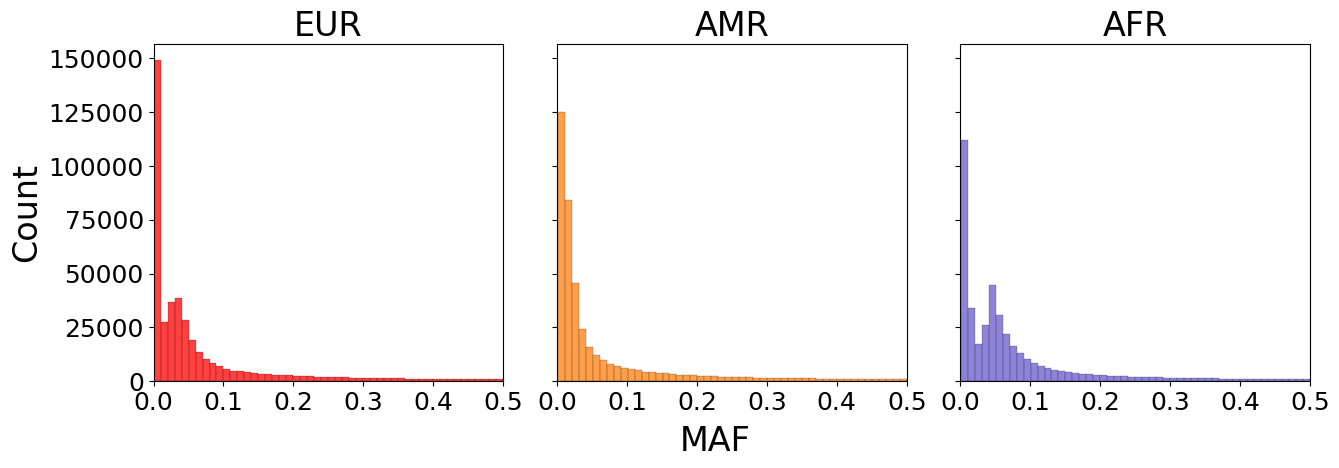

In [13]:
eur = af_eur
amr = af_amr
afr = af_afr

# Create a figure with a row of three subplots
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

# Plot each histogram in its respective subplot
sns.histplot(eur, bins=100, kde=False, color='red', ax=axes[0])
axes[0].set_title("EUR", fontsize=24)
axes[0].set_ylabel("Count", fontsize=24)
axes[0].set_xlabel('', fontsize=20)
axes[0].set_xlim(0, 0.5)

sns.histplot(amr, bins=100, kde=False, color='#ff7f0e', ax=axes[1])
axes[1].set_title("AMR", fontsize=24)
axes[1].set_xlabel('', fontsize=20)
axes[1].set_xlim(0, 0.5)

sns.histplot(afr, bins=100, kde=False, color='slateblue', ax=axes[2])
axes[2].set_title("AFR", fontsize=24)
axes[2].set_xlabel('', fontsize=20)
axes[2].set_xlim(0, 0.5)

# Set a shared x-axis label
fig.text(0.8, -0.02, 'MAF', ha='center', fontsize=24)

# Increase tick label font size for all axes
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=18)

# Adjust the number of ticks on x-axis and y-axis if needed
for ax in axes:
    ax.set_xticks([i * 0.1 for i in range(6)])  # Example for 0, 0.1, 0.2,..., 0.5
    ax.set_yticks(range(0, 150001, 25000)) 
    
# Adjust layout and space between subplots
plt.tight_layout(rect=[0, 0.05, 1.5, 1.5], w_pad=1)  # Increase w_pad for more space between subplots

# Show the plot
plt.show()

In [36]:
## Summarize allele frequency for each ancestry
# Convert the collected list to a pandas Series
af_eur_series = pd.Series(af_eur, name="AF EUR")
af_amr_series = pd.Series(af_amr, name="AF AMR")
af_afr_series = pd.Series(af_afr, name="AF AFR")

print("EUR AF Summary:")
print(af_eur_series.describe())

print("\nAMR AF Summary:")
print(af_amr_series.describe())

print("\nAFR AF Summary:")
print(af_afr_series.describe())

EUR AF Summary:
count    465726.000000
mean          0.131309
std           0.229714
min           0.000000
25%           0.001166
50%           0.034882
75%           0.118525
max           0.999978
Name: AF EUR, dtype: float64

AMR AF Summary:
count    465726.000000
mean          0.131440
std           0.229525
min           0.001427
25%           0.010614
50%           0.025588
75%           0.119903
max           0.997950
Name: AF AMR, dtype: float64

AFR AF Summary:
count    465726.000000
mean          0.141094
std           0.225517
min           0.000460
25%           0.011137
50%           0.049971
75%           0.131537
max           0.998886
Name: AF AFR, dtype: float64


In [39]:
from scipy.stats import ttest_ind

# Perform an independent t-test
t_stat, p_value = ttest_ind(af_eur_series, af_amr_series, nan_policy='omit')

# Display the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -0.2747294593594227
P-value: 0.7835241573440235


In [40]:
# Perform an independent t-test
t_stat, p_value = ttest_ind(af_eur_series, af_afr_series, nan_policy='omit')

# Display the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -20.74368031181572
P-value: 1.4696369882058088e-95


In [41]:
# Perform an independent t-test
t_stat, p_value = ttest_ind(af_amr_series, af_afr_series, nan_policy='omit')

# Display the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -20.475134262131796
P-value: 3.7616633878403027e-93


## AF correlation scatter plot

In [6]:
array_HDL_eur = hl.read_table(f"{bucket}/AF/array_HDL_eur.ht")
array_HDL_amr = hl.read_table(f"{bucket}/AF/array_HDL_amr.ht")
array_HDL_afr = hl.read_table(f"{bucket}/AF/array_HDL_afr.ht")

In [7]:
wgs_HDL_eur = hl.read_table(f"{bucket}/AF/wgs_HDL_eur.ht")
wgs_HDL_amr = hl.read_table(f"{bucket}/AF/wgs_HDL_amr.ht")
wgs_HDL_afr = hl.read_table(f"{bucket}/AF/wgs_HDL_afr.ht")

In [8]:
# Extract loci from array_HDL_afr
array_loci = array_HDL_afr.key_by('locus').select()  # Ensure the key is 'locus'

# Filter wgs_HDL_afr to include only loci present in array_HDL_afr
filtered_wgs_HDL_afr = wgs_HDL_afr.semi_join(array_loci)

# Verify the filtered table
print(filtered_wgs_HDL_afr.count())

2024-11-27 01:28:47.458 Hail: INFO: wrote table with 261583 rows in 74 partitions to /tmp/__iruid_7-0DZWHMynlzM3NFQOLCv74E


59234


In [12]:
filtered_wgs_HDL_afr.export(f"{bucket}/AF/filtered_wgs_HDL_afr.gz")

2024-11-27 02:06:24.867 Hail: INFO: wrote table with 261583 rows in 74 partitions to /tmp/__iruid_1850-w3zVh1tHcTWvauwI2qs9gR
2024-11-27 02:20:28.660 Hail: INFO: merging 140127 files totalling 4.0M...40126]
2024-11-27 02:23:09.588 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/filtered_wgs_HDL_afr.gz
  merge time: 2m40.9s


In [22]:
# Extract loci from array_HDL_eur
array_loci = array_HDL_eur.key_by('locus').select()  # Ensure the key is 'locus'

# Filter wgs_HDL_eur to include only loci present in array_HDL_eur
filtered_wgs_HDL_eur = wgs_HDL_eur.semi_join(array_loci)

filtered_wgs_HDL_eur.export(f"{bucket}/AF/filtered_wgs_HDL_eur.gz")

2024-11-27 02:46:23.541 Hail: INFO: wrote table with 261583 rows in 74 partitions to /tmp/__iruid_2818-HyfRAjD2MOJJKwfn23ZFMO
2024-11-27 02:59:40.682 Hail: INFO: merging 140127 files totalling 4.0M...40126]
2024-11-27 03:02:22.715 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/filtered_wgs_HDL_eur.gz
  merge time: 2m42.0s


In [23]:
# Extract loci from array_HDL_amr
array_loci = array_HDL_amr.key_by('locus').select()  # Ensure the key is 'locus'

# Filter wgs_HDL_amr to include only loci present in array_HDL_amr
filtered_wgs_HDL_amr = wgs_HDL_amr.semi_join(array_loci)

filtered_wgs_HDL_amr.export(f"{bucket}/AF/filtered_wgs_HDL_amr.gz")

2024-11-27 03:06:23.435 Hail: INFO: wrote table with 261583 rows in 74 partitions to /tmp/__iruid_3786-LSe6U4RKWpYQkQgiNSaXHX
2024-11-27 03:22:53.307 Hail: INFO: merging 140127 files totalling 4.0M...40126]
2024-11-27 03:25:24.997 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/filtered_wgs_HDL_amr.gz
  merge time: 2m31.7s


In [18]:
array_HDL_afr = pd.read_csv(f"{bucket}/AF/array_HDL_afr.gz",sep = "\t")
filtered_wgs_HDL_afr = pd.read_csv(f"{bucket}/AF/filtered_wgs_HDL_afr.gz",sep = "\t")

array_HDL_eur = pd.read_csv(f"{bucket}/AF/array_HDL_eur.gz",sep = "\t")
filtered_wgs_HDL_eur = pd.read_csv(f"{bucket}/AF/filtered_wgs_HDL_eur.gz",sep = "\t")

array_HDL_amr = pd.read_csv(f"{bucket}/AF/array_HDL_amr.gz",sep = "\t")
filtered_wgs_HDL_amr = pd.read_csv(f"{bucket}/AF/filtered_wgs_HDL_amr.gz",sep = "\t")

In [20]:
# Perform an inner join to keep only intersecting loci
df_merged_afr = pd.merge(array_HDL_afr, filtered_wgs_HDL_afr, on='locus', how='inner')
df_merged_eur = pd.merge(array_HDL_eur, filtered_wgs_HDL_eur, on='locus', how='inner')
df_merged_amr = pd.merge(array_HDL_amr, filtered_wgs_HDL_amr, on='locus', how='inner')

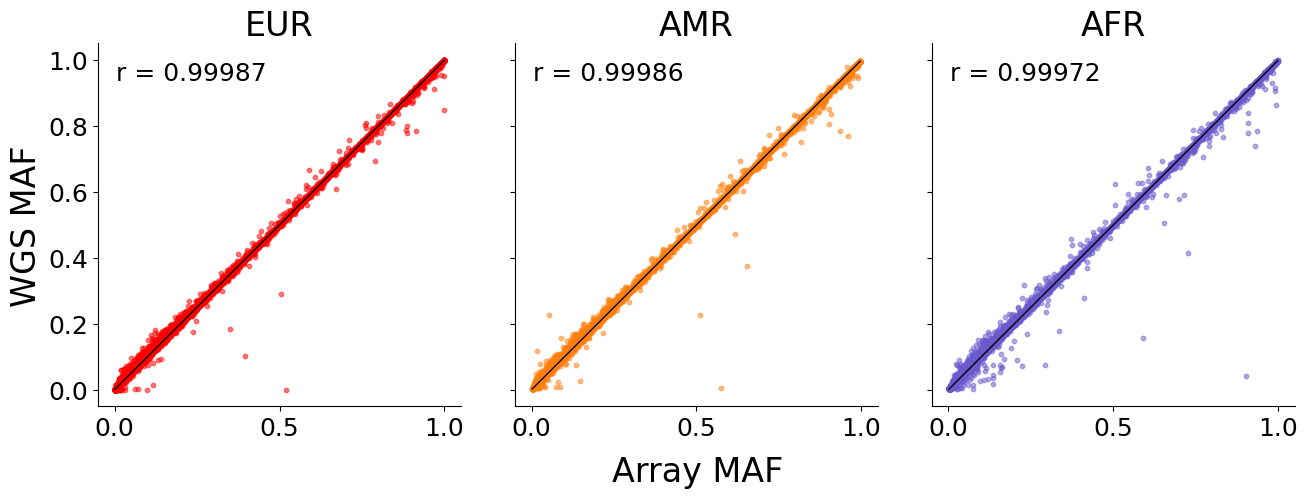

In [83]:
# Create subplots with shared x and y axis
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, sharex=True)

# --- EUR Plot ---
df = df_merged_eur
correlation = np.corrcoef(df['allele_freq_x'], df['allele_freq_y'])[0, 1]
sns.regplot(x='allele_freq_x', y='allele_freq_y', data=df, 
            scatter_kws={'alpha': 0.5, 's': 10, 'color': 'red'}, 
            line_kws={'color': 'black', 'linewidth': 1}, ci=None, ax=axes[0])
axes[0].set_title('EUR', fontsize=24)
axes[0].set_ylabel('WGS MAF', fontsize=24)
axes[0].set_xlabel('')
axes[0].tick_params(axis='both', which='major', labelsize=18)  # Set font size for ticks
axes[0].text(0.05, 0.95, f'r = {correlation:.5f}', ha='left', va='top', 
             transform=axes[0].transAxes, color='black', fontsize=18)
axes[0].set_aspect('equal', adjustable='box')  # Ensure the plot is square
sns.despine(ax=axes[0])  # Remove top and right spines

# --- AMR Plot ---
df = df_merged_amr
correlation = np.corrcoef(df['allele_freq_x'], df['allele_freq_y'])[0, 1]
sns.regplot(x='allele_freq_x', y='allele_freq_y', data=df, 
            scatter_kws={'alpha': 0.5, 's': 10, 'color': '#ff7f0e'}, 
            line_kws={'color': 'black', 'linewidth': 1}, ci=None, ax=axes[1])
axes[1].set_title('AMR', fontsize=24)
axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=18)  # Set font size for ticks
axes[1].text(0.05, 0.95, f'r = {correlation:.5f}', ha='left', va='top', 
             transform=axes[1].transAxes, color='black', fontsize=18)
axes[1].set_aspect('equal', adjustable='box')  # Ensure the plot is square
sns.despine(ax=axes[1])  # Remove top and right spines

# --- AFR Plot ---
df = df_merged_afr
correlation = np.corrcoef(df['allele_freq_x'], df['allele_freq_y'])[0, 1]
sns.regplot(x='allele_freq_x', y='allele_freq_y', data=df, 
            scatter_kws={'alpha': 0.5, 's': 10, 'color': 'slateblue'}, 
            line_kws={'color': 'black', 'linewidth': 1}, ci=None, ax=axes[2])
axes[2].set_title('AFR', fontsize=24)
axes[2].set_xlabel('')
axes[2].tick_params(axis='both', which='major', labelsize=18)  # Set font size for ticks
axes[2].text(0.05, 0.95, f'r = {correlation:.5f}', ha='left', va='top', 
             transform=axes[2].transAxes, color='black', fontsize=18)
axes[2].set_aspect('equal', adjustable='box')  # Ensure the plot is square
sns.despine(ax=axes[2])  # Remove top and right spines

# Hide y-axis tick labels for all subplots except the first one
for ax in axes[1:]:
    ax.set_ylabel('')
    ax.tick_params(axis='y', which='both', labelleft=False)

# Set a shared x-axis label (below the entire figure)
fig.text(0.8, -0.08, 'Array MAF', ha='center', fontsize=24)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0.05, 1.5, 1.5], w_pad=1)  # Adjust spacing
plt.show()